# Brain MRI - Image Segmentation
------

In [1]:
import os
import PIL
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torchvision.transforms.functional as F
from torchvision import transforms as transforms
import torch.nn as nn
import torch
from torchsummary import summary

from imgseg import show, plot_random_masked_images, plot_one_image_mask
from imgseg import DoubleConvLayer, UNet4, UNet3
from imgseg import get_dataloader, SegmentationDataset
from imgseg import TrainingInterface, DiceLoss

## Create Folder, Organize Data

In [2]:
if not os.path.isdir('./kaggle_3m/images'):
    os.mkdir('./kaggle_3m/images')
if not os.path.isdir('./kaggle_3m/masks'):
    os.mkdir('./kaggle_3m/masks')

In [3]:
all_images = []
def unpack_folder(path: str):
    """Unpacks folder recusrively and appends to global list."""
    files = os.listdir(path)
    for f in files:
        if '.tif' in f:
            all_images.append(os.path.join(path, f))
        elif os.path.isdir(os.path.join(path, f)):
            unpack_folder(os.path.join(path, f)) 

In [4]:
unpack_folder('kaggle_3m/')
all_images[:5]

['kaggle_3m/images/TCGA_CS_4941_19960909_1.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_10.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_11.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_12.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_13.tif']

In [5]:
REPLACE_FILES = False
new_path_images = './kaggle_3m/images/'
new_path_masks = './kaggle_3m/masks/'

if REPLACE_FILES:
    for file in tqdm(all_images):
        img = Image.open(file)
        name = os.path.split(file)[-1]
        if 'mask' in name and name not in os.listdir(new_path_masks):
            img.save(os.path.join(new_path_masks, name))
        elif name not in os.listdir(new_path_images):
            img.save(os.path.join(new_path_images, name))

In [6]:
# build pandas dataset linking each mask with the real image
all_images = os.listdir(new_path_images)
all_masks = os.listdir(new_path_masks)
identifier = [img.split('.')[0] for img in all_images]

In [7]:
df_images = pd.DataFrame({'identifier': identifier, 'image': all_images})
df_masks = pd.DataFrame({'mask':all_masks})
df_masks['identifier'] = df_masks['mask'].apply(lambda x: x.split('_mask.tif')[0])
df = pd.merge(left=df_images, right=df_masks, on='identifier', how='inner')
df['patient_key'] = df['identifier'].apply(lambda x: '_'.join(x.split('_')[:-2]))

df.head(2)

,identifier,image,mask,patient_key
0,TCGA_CS_4941_19960909_1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,TCGA_CS_4941
1,TCGA_CS_4941_19960909_10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,TCGA_CS_4941


In [8]:
assert df.isnull().sum().sum() == 0

## Visualize Scans with Masks

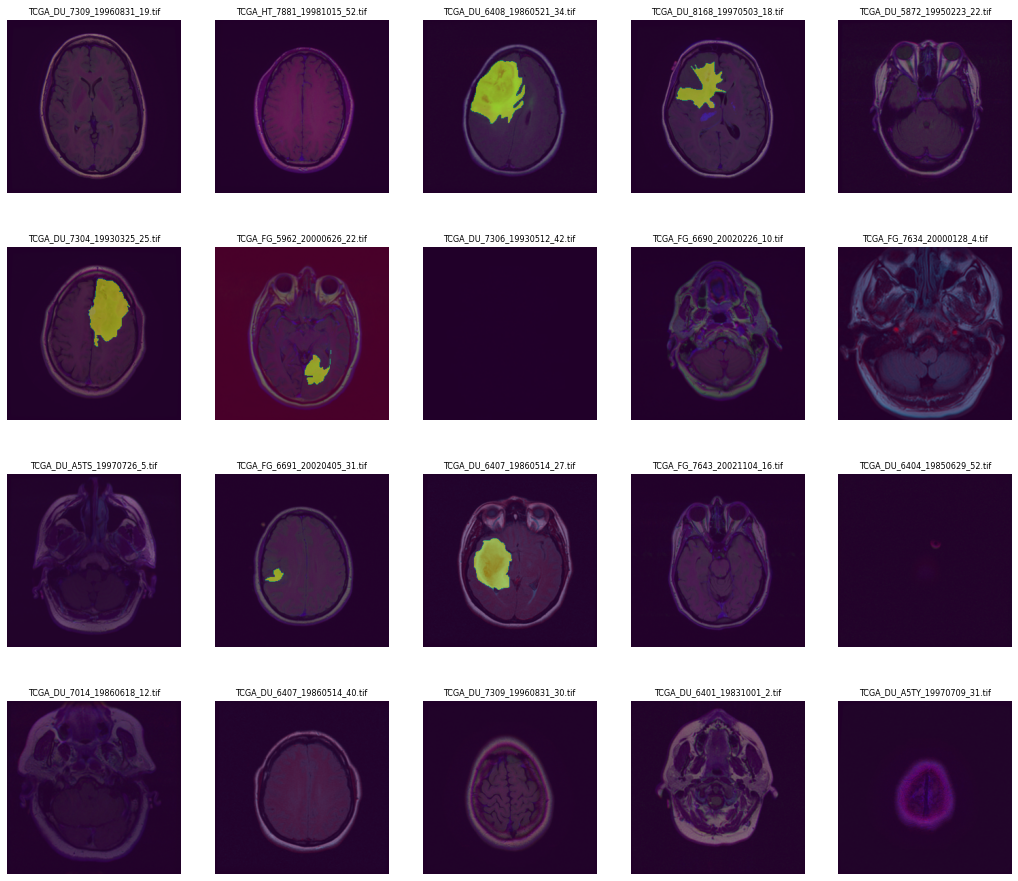

In [9]:
plot_random_masked_images(df, 20)

**Comment:**

The images show different MRI Scans of human brains. The scans differ in the recorded height of the head, because for each directory there was one recording of a brain, which corresponds to one patient probably. The folders contain height sequences of human brains with respective masks. Thus, the images where only analyzed and modelled based on single height sequences resulting in a 1-D Image.

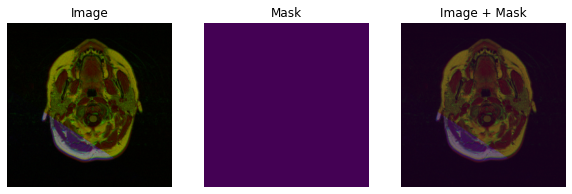

In [10]:
plot_one_image_mask(df, 'TCGA_FG_7643_20021104_3.tif')

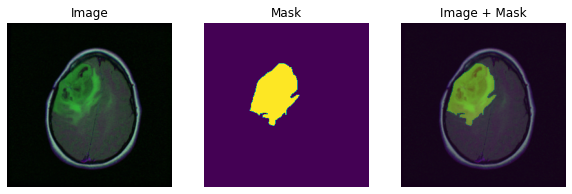

In [44]:
plot_one_image_mask(df, 'TCGA_DU_6408_19860521_36.tif')

**Commnent:**

Here we have a look on an image without a segmentation mask and one with segmenation mask. The segmentation masks are labelled with 0's representing no tumor and 1's representing tumor.

In [11]:
PREPARE_DF = False

if PREPARE_DF:
    def make_mask_label(img_path):
        img_path = os.path.join('./kaggle_3m/masks/', img_path)
        img = np.asarray(PIL.Image.open(img_path))
        return True if img.sum() > 0 else False 
    
    df['has_segment_mask'] = df['mask'].apply(make_mask_label)
    
    if SAVE_DF:
        df.to_csv('./kaggle_3m/image_data.csv', index=False)
        
else:
    df = pd.read_csv('./kaggle_3m/image_data.csv')

In [12]:
df.head(2)

,identifier,image,mask,patient_key,has_segment_mask,set
0,TCGA_FG_A4MT_20020212_15,TCGA_FG_A4MT_20020212_15.tif,TCGA_FG_A4MT_20020212_15_mask.tif,TCGA_FG_A4MT,True,train
1,TCGA_DU_6407_19860514_30,TCGA_DU_6407_19860514_30.tif,TCGA_DU_6407_19860514_30_mask.tif,TCGA_DU_6407,True,train


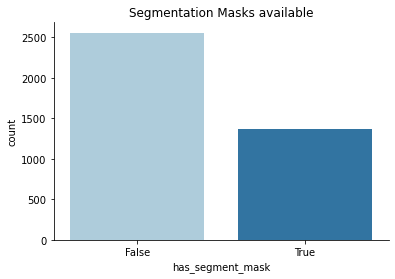

In [13]:
p = sns.countplot(x=df['has_segment_mask'], palette='Paired')
p.set_title('Segmentation Masks available')
sns.despine()
plt.show()

**Comment:**

Our dataset contains mostly of images without tumors. These pictures can also belong to heights where no part of tumor was located. We have approx half the amount of images with segmentation masks (tumors) than without segmentation masks.

In [15]:
df.head(2)

,identifier,image,mask,patient_key,has_segment_mask,set
0,TCGA_FG_A4MT_20020212_15,TCGA_FG_A4MT_20020212_15.tif,TCGA_FG_A4MT_20020212_15_mask.tif,TCGA_FG_A4MT,True,train
1,TCGA_DU_6407_19860514_30,TCGA_DU_6407_19860514_30.tif,TCGA_DU_6407_19860514_30_mask.tif,TCGA_DU_6407,True,train


In [16]:
BUILD_SET = False

if BUILD_SET:
    train, test = train_test_split(df, test_size=.1, random_state=10, stratify=df['has_segment_mask'])
    val, test = train_test_split(test, test_size=.5, random_state=10, stratify=test['has_segment_mask'])
    train['set'] = 'train'
    val['set'] = 'val'
    test['set'] = 'test'
    df = pd.concat([train, val, test], axis=0)
    df.to_csv('./kaggle_3m/image_data.csv', index=False)

In [17]:
# image dim
PIL.Image.open(os.path.join(new_path_images, 
                            df.loc[0, 'image'])).size

(256, 256)

The images are dimensionend on 1x256x256 sized images.

## Build Model, Implementation of U-Net

<img src="./doc/u-net-architecture.png" width=500 align="center">

The raw code of the U-Net implementation can be found in the folder `./imgseg/networks.py`. 
How does my implementation differ from the proposed one in the paper of [(Ronneberger et al., 2015)](https://arxiv.org/abs/1505.04597):

- Used 3 skip connections rather than 4 to decrease model complexity. (7Mio. Params vs 31 Mio. Params)
- Added padding of 1 in each Double Convolutional Layer to maintain the size over Double Conv layer. It makes it also possible to reproduce the same output dimensions with the decoder part of the network.
- Add batchnorm to each Double Conv Layer.
- Used one output activation map with sigmoid activations than 2 outputs.

In [21]:
summary(DoubleConvLayer(1, 64), input_size=(1, 572, 572), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 572, 572]             640
       BatchNorm2d-2         [-1, 64, 572, 572]             128
              ReLU-3         [-1, 64, 572, 572]               0
            Conv2d-4         [-1, 64, 572, 572]          36,928
       BatchNorm2d-5         [-1, 64, 572, 572]             128
              ReLU-6         [-1, 64, 572, 572]               0
Total params: 37,824
Trainable params: 37,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.25
Forward/backward pass size (MB): 958.55
Params size (MB): 0.14
Estimated Total Size (MB): 959.94
----------------------------------------------------------------


In [22]:
summary(UNet3(in_channels=1, out_channels=1), input_size=(1, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
   DoubleConvLayer-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [23]:
image, mask = df.loc[0, ['image', 'mask']].values

In [24]:
image, mask

('TCGA_FG_A4MT_20020212_15.tif', 'TCGA_FG_A4MT_20020212_15_mask.tif')

## Setup Dataloader

In [25]:
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(256, 256)),
    transforms.RandAugment(num_ops=2, magnitude=6),
    transforms.ToTensor(),
])

image_transforms_inference = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

In [26]:
dataloader = get_dataloader(image_dir='./kaggle_3m/images/', 
                            mask_dir='./kaggle_3m/masks/', 
                            df=pd.read_csv('./kaggle_3m/image_data.csv'), 
                            transformations=image_transforms,
                            batch_size=1, workers=1,)

In [27]:
img, seg = next(iter(dataloader))

In [28]:
img.shape, seg.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]))

## Model Training

Mentions on the training of my network:

I witnessed bad segmentation outputs with only the BCE-loss on my output maps. I switched to the Dice-Loss coefficient:

$$DICE(A, B)=\frac{2*|A \cap B|}{|A| + |B|}$$

In the numerator the count of the intersection between $A$ and $B$ is calculated and then divided by the overall counts of $A$ and $B$. The better the predicted masks covers the true mask the better returned DICE-Loss.


- SGD with momentum 0.99

In [39]:
df = pd.read_csv('./kaggle_3m/image_data.csv')
df.sample(2)

,identifier,image,mask,patient_key,has_segment_mask,set
2073,TCGA_DU_5871_19941206_24,TCGA_DU_5871_19941206_24.tif,TCGA_DU_5871_19941206_24_mask.tif,TCGA_DU_5871,True,train
128,TCGA_HT_8563_19981209_23,TCGA_HT_8563_19981209_23.tif,TCGA_HT_8563_19981209_23_mask.tif,TCGA_HT_8563,False,train


In [ ]:
# Compute class weights for sampler
classes =  np.unique(df['has_segment_mask'])
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=classes, 
                                     y=df['has_segment_mask'])
weights_replace_with = dict(zip(classes, class_weights))
df['class_weight'] = df['has_segment_mask'].replace(weights_replace_with)
df.head(2)

In [40]:
train = df[df['set'] == 'train'].reset_index(drop=True)
val = df[df['set'] == 'val'].reset_index(drop=True)
test = df[df['set'] == 'test'].reset_index(drop=True)

sampler = WeightedRandomSampler(weights=train['class_weight'].to_numpy(),
                                num_samples=train.shape[0], 
                                replacement=True)

dataloader_train = get_dataloader(image_dir='./kaggle_3m/images/', 
                                  mask_dir='./kaggle_3m/masks/', 
                                  df=train,
                                  transformations=image_transforms,
                                  batch_size=8, workers=1,
                                  sampler=sampler)

dataloader_val = get_dataloader(image_dir='./kaggle_3m/images/', 
                                  mask_dir='./kaggle_3m/masks/', 
                                df=val,
                                transformations=image_transforms_inference,
                                batch_size=8, workers=1,)

dataloader_test = get_dataloader(image_dir='./kaggle_3m/images/', 
                                  mask_dir='./kaggle_3m/masks/',
                                  df=test,
                                  transformations=image_transforms_inference,
                                  batch_size=8, workers=1)

In [41]:
unet = UNet3(in_channels=1, out_channels=1)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(params=unet.parameters(), lr=.0001, momentum=.5)

In [42]:
interface = TrainingInterface(model=unet, name='Unet3')

In [ ]:
interface.train(
    criterion=criterion,
    optimizer=optimizer, 
    n_epochs=3, 
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    verbose=True
)

In [ ]:
y_true, y_pred, images = interface.segment(dataloader=dataloader_test, return_images=True)

In [ ]:
for idx in range(0, 20):
    PLOT_ID = idx
    true_mask = inverse_image_transforms(y_true[PLOT_ID])
    pred_mask = inverse_image_transforms(y_pred[PLOT_ID])
    image = inverse_image_transforms(images[PLOT_ID])

    fig, ax = plt.subplots(figsize=(15, 4))

    plt.subplot(1,3,1)
    plt.imshow(image, cmap='Greys_r')
    plt.subplot(1,3,2)
    plt.imshow(true_mask)
    plt.subplot(1,3,3)
    plt.imshow(pred_mask)

    plt.show()

## Sources

different loss: https://www.codetd.com/en/article/9915075

training tricks: https://neptune.ai/blog/image-segmentation-tips-and-tricks-from-kaggle-competitions